# Part 2: Predicting the masses of planets

## [Expolanet Archive](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html)
#href [column-definitions](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html)

In [12]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.optimize as opt
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

import pydotplus
from IPython.display import Image


In [13]:
# all_data = requests.get('https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=json')

In [14]:
# all_data
data = pd.read_csv('exoplanets.csv')

/var/folders/_p/y56kr6vs1fz7ycsbxhyqwwwc0000gn/T/ipykernel_15886/1211431087.py:2: DtypeWarning: Columns (65,80,163,168,198,202,221,226,252,257) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('exoplanets.csv')


In [15]:
# data = pd.DataFrame(all_data.json())
data.head()

,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,...,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2
0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,13.692,13.314,0.121,-0.121,13.314&plusmn;0.121,12.856,NaN,NaN
1,1,1,1,1,1,1,1,1,1,1,...,0.020,-0.020,7.96&plusmn;0.02,7.498,0.047,-0.047,7.498&plusmn;0.047,7.323,0.021,-0.021
2,2,2,2,2,2,2,2,2,2,2,...,0.020,-0.020,7.96&plusmn;0.02,7.498,0.047,-0.047,7.498&plusmn;0.047,7.323,0.021,-0.021
3,3,3,3,3,3,3,3,3,3,3,...,0.027,-0.027,5.383&plusmn;0.027,5.280,0.018,-0.018,5.280&plusmn;0.018,5.240,0.018,-0.018
4,4,4,4,4,4,4,4,4,4,4,...,0.226,-0.226,4.112&plusmn;0.226,3.547,0.194,-0.194,3.547&plusmn;0.194,3.274,0.304,-0.304


In [16]:
# save data
data.to_csv('exoplanets.csv')

In [17]:
data.columns

# show all cols
# for col in data.columns:
#     print (col)

Index(['Unnamed: 0.14', 'Unnamed: 0.13', 'Unnamed: 0.12', 'Unnamed: 0.11',
       'Unnamed: 0.10', 'Unnamed: 0.9', 'Unnamed: 0.8', 'Unnamed: 0.7',
       'Unnamed: 0.6', 'Unnamed: 0.5',
       ...
       'sy_jmagerr1', 'sy_jmagerr2', 'sy_jmagstr', 'sy_hmag', 'sy_hmagerr1',
       'sy_hmagerr2', 'sy_hmagstr', 'sy_kmag', 'sy_kmagerr1', 'sy_kmagerr2'],
      dtype='object', length=368)

In [18]:
test_data = data[['pl_eqt', 'pl_name', 'pl_trandep', 'pl_trandur' , 'st_teff', 'st_rad', 'st_mass', 'st_lum', 'pl_masse']]
# test_data = data.copy().drop(columns=['pl_rade', 'pl_dens', 'pl_rvamp']) <<-- ignoring key variables
test_data = test_data.dropna(how='any').set_index('pl_name')
test_data.head()

,pl_eqt,pl_trandep,pl_trandur,st_teff,st_rad,st_mass,st_lum,pl_masse
pl_name,,,,,,,,
TOI-3807 b,1646.0,1.3600,1.7800,5772.0,1.47,1.18,0.332,330.54154
TOI-4087 b,1458.0,1.1565,2.9842,6060.0,1.11,1.18,0.176,232.01474
TOI-2818 b,1376.0,1.3000,3.8040,5721.0,1.23,0.98,0.164,225.65817
TOI-4463 A b,1395.0,1.3110,1.8500,5640.0,1.06,1.06,0.011,252.35576
TOI-3785 b,582.0,0.9254,1.7000,3576.0,0.50,0.52,-1.435,14.95000


In [19]:
test_data.dtypes

pl_eqt        float64
pl_trandep    float64
pl_trandur    float64
st_teff       float64
st_rad        float64
st_mass       float64
st_lum        float64
pl_masse      float64
dtype: object

In [20]:
features = test_data.copy().drop(columns = 'pl_masse')
target = test_data['pl_masse']

## Decision Trees 
- Testing which model performs better with variables 'pl_rade', 'pl_dens', 'pl_rvamp'

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size = 0.3)

model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)


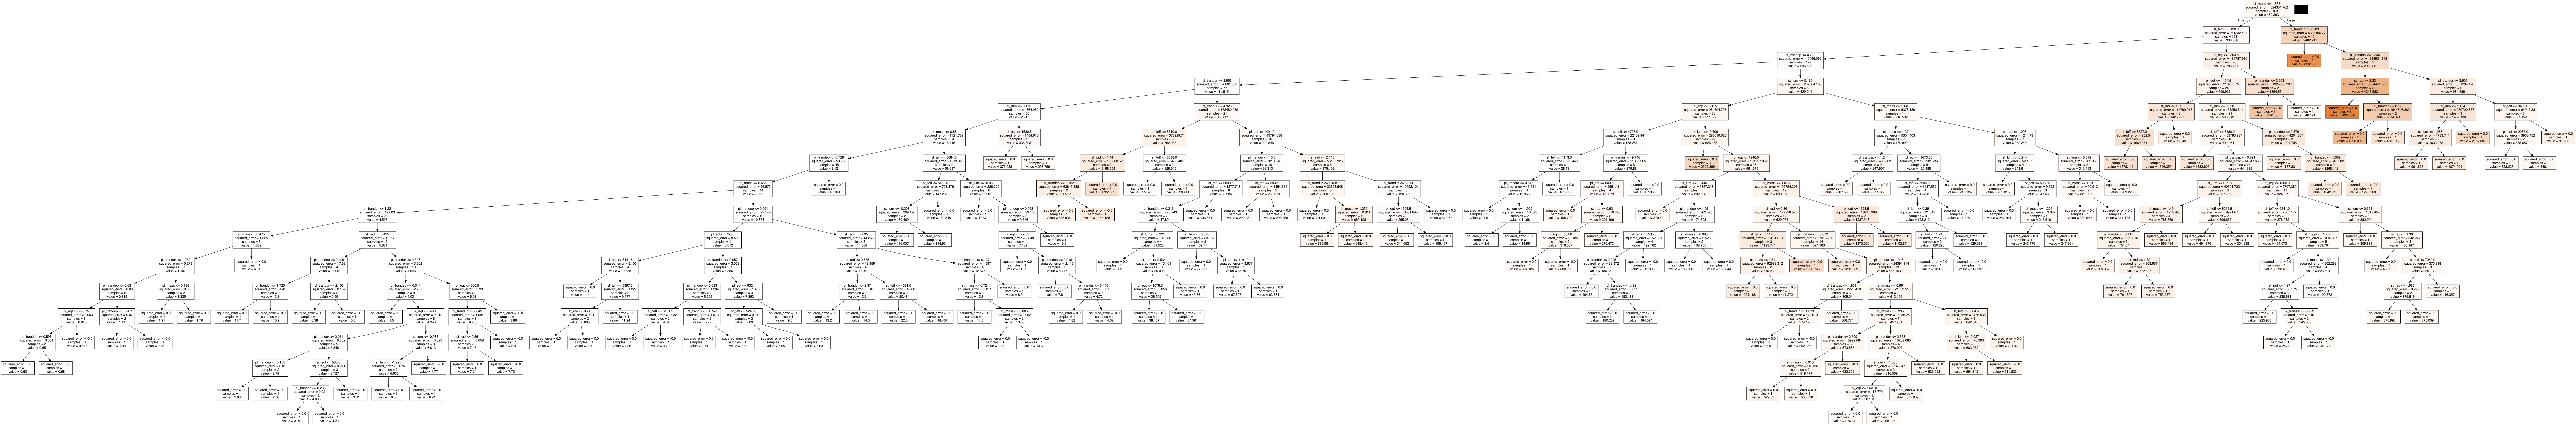

In [22]:
# Create DOT data
dot_data = tree.export_graphviz(
    model_dt, out_file=None, feature_names=features.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

### Metrics

In [23]:
# metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)

print('Mean absolute error:', mae_dt)
print('Mean squared error:', mse_dt)

Mean absolute error: 356.67661000000004
Mean squared error: 447898.95898404106


In [24]:
fig_dt = px.scatter(title='Actual vs Predicted using Decision Trees')
fig_dt.add_scatter(x=X_test['pl_trandur'], y=y_test, mode='markers', name='y_test')
fig_dt.add_scatter(x=X_test['pl_trandur'], y=y_pred_dt, mode='markers', name='y_pred', opacity=0.7)

fig_dt.update_yaxes(title_text='mass')
fig_dt.show()


In [25]:
def linear(x, *p):
    return p[0]*x+p[1]

popt, pcov = opt.curve_fit(linear, y_test, y_pred_dt, p0 = (0,0))
popt

x_dt = y_test
line_dt = [popt[0]*i+popt[1] for i in x_dt]


In [26]:
fig_dt_fit = go.Figure()
fig_dt_fit.add_trace(go.Scatter(x = y_test, y = y_pred_dt, mode ='markers', showlegend=False))
fig_dt_fit.add_trace(go.Scatter(x=x_dt, y=line_dt, mode = 'lines', line=dict(dash='dot'), showlegend=False))
fig_dt_fit.update_xaxes(title_text='y_test')
fig_dt_fit.update_yaxes(title_text='y_pred')
fig_dt_fit.update_layout(title='Linear Regression of y_pred vs. y_test')

fig_dt_fit.show()

In [27]:
pd.DataFrame(model_dt.feature_importances_)

,0
0,0.054395
1,0.211879
2,0.176834
3,0.075034
4,0.102100
5,0.331625
6,0.048133


### Feature importances

In [28]:
features_dt_df = pd.DataFrame(model_dt.feature_importances_, index=features.columns).reset_index().rename(columns={'index':'vals', 0:'importance'})
# plt.bar(features.columns, model.feature_importances_)
fig = px.bar(features_dt_df, x="vals", y="importance", title="Feature importances").update_xaxes(categoryorder='total descending')
fig.show()

## Random forests

In [29]:
rf_model = RandomForestRegressor(random_state=42)
rf_model = rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

### Metrics

In [30]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
evs_rf = explained_variance_score(y_test, y_pred_rf)

print('Mean absolute error:', mae_dt)
print('Mean squared error:', mse_dt)

Mean absolute error: 356.67661000000004
Mean squared error: 447898.95898404106


In [31]:
# linear fit
def linear(x, *p):
    return p[0]*x+p[1]

popt, pcov = opt.curve_fit(linear, y_test, y_pred_rf, p0 = (0,0))
popt

x_rf = y_test
line_rf = [popt[0]*i+popt[1] for i in x_rf]

In [32]:
fig_rf_fit = go.Figure()
fig_rf_fit.add_trace(go.Scatter(x=X_test['pl_trandur'], y=y_test, mode='markers', name='y_test'))
fig_rf_fit.add_trace(go.Scatter(x=X_test['pl_trandur'], y=y_pred_rf, mode='markers', name='y_pred', opacity=0.7))
fig_rf_fit.update_yaxes(title_text='mass')
fig_rf_fit.update_layout(title='Actual vs Predicted using Random Forest')

fig_rf_fit.show()

In [33]:
np.median(np.abs(y_test-y_pred_rf))

179.56984930000004

### Feature importances

In [34]:
features_dt_rf = pd.DataFrame(rf_model.feature_importances_, index=features.columns).reset_index().rename(columns={'index':'vals', 0:'importance'})
# plt.bar(features.columns, model.feature_importances_)
fig = px.bar(features_dt_rf, x="vals", y="importance", title="Feature importances").update_xaxes(categoryorder='total descending')
fig.show()

## Results

Text(0.5, 0, 'Mass')

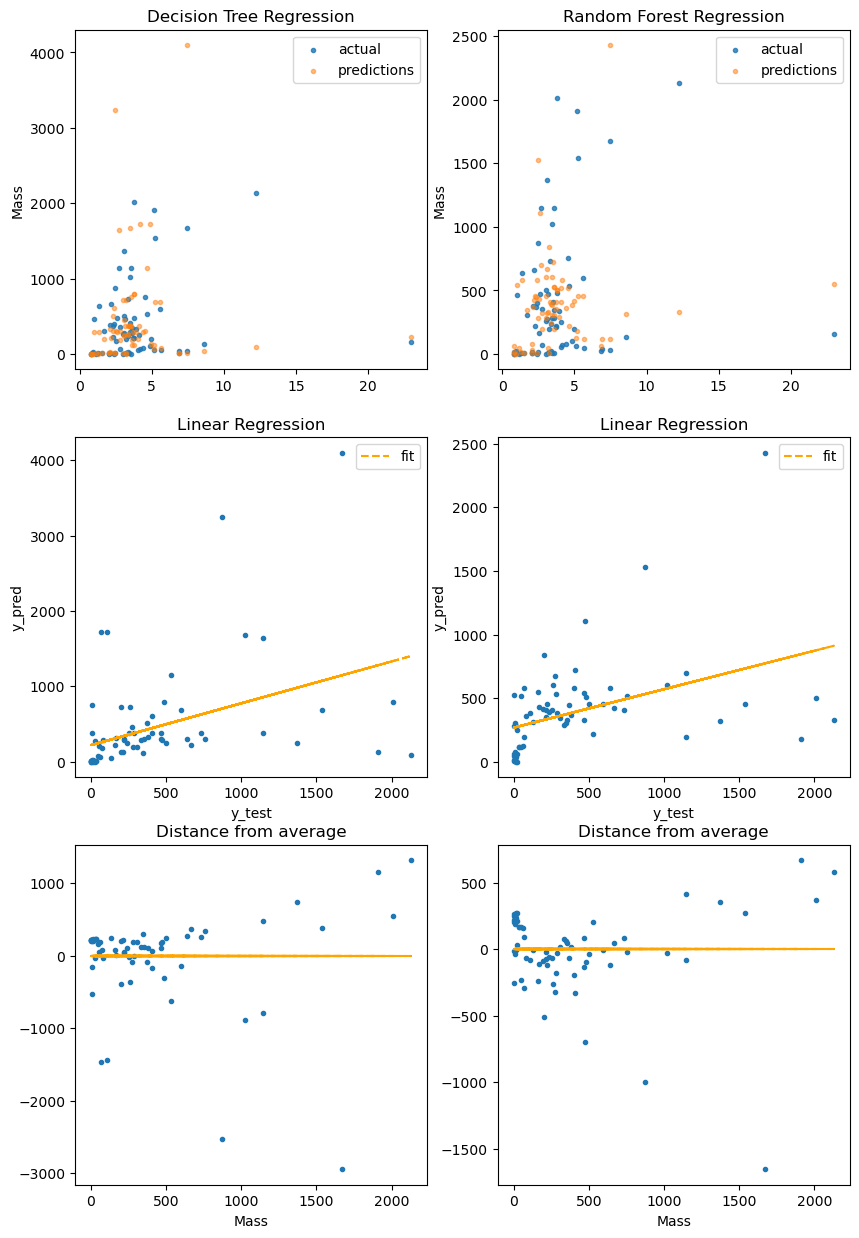

In [35]:
fig, axes = plt.subplots(nrows = 3, ncols = 2)

fig.set_figheight(15)
fig.set_figwidth(10)

axes[0,0].set_title('Decision Tree Regression')
axes[0,0].scatter(X_test['pl_trandur'], y_test, alpha = .8, marker = '.', label = 'actual')
axes[0,0].scatter(X_test['pl_trandur'], y_pred_dt, alpha = .5, marker = '.', label = 'predictions')
axes[0,0].set_ylabel('Mass')
axes[0,0].legend()

axes[1,0].scatter(y_test, y_pred_dt, marker = '.')
axes[1,0].plot(x_dt, line_dt, '--', color = 'orange', label = 'fit')
axes[1,0].set_title('Linear Regression')
axes[1,0].set_xlabel('y_test')
axes[1,0].set_ylabel('y_pred')
axes[1,0].legend()

axes[0,1].scatter(X_test['pl_trandur'], y_test, alpha = .8, marker = '.', label = 'actual')
axes[0,1].scatter(X_test['pl_trandur'], y_pred_rf, alpha = .5, marker = '.', label = 'predictions')
axes[0,1].set_title('Random Forest Regression')
axes[0,1].set_ylabel('Mass')
axes[0,1].legend()

axes[1,1].scatter(y_test, y_pred_rf, marker = '.')
axes[1,1].plot(x_rf, line_rf, '--', color = 'orange', label = 'fit')
axes[1,1].set_title('Linear Regression')
axes[1,1].set_xlabel('y_test')
axes[1,1].set_ylabel('y_pred')
axes[1,1].legend()

axes[2, 0].scatter(x_dt, line_dt-y_pred_dt, marker = '.')
axes[2, 0].plot(x_dt, [0]*len(x_dt), '--', color = 'orange')
axes[2, 0].set_title('Distance from average')
axes[2, 0].set_xlabel('Mass')


axes[2, 1].scatter(x_rf, line_rf-y_pred_rf, marker = '.')
axes[2, 1].plot(x_rf, [0]*len(x_rf), '--', color = 'orange')
axes[2, 1].set_title('Distance from average')
axes[2, 1].set_xlabel('Mass')

# fig.savefig('with_MTD.jpg')

#### Median differences

In [36]:
def median_diff(predicted, actual):
  median = np.median(np.abs(predicted-actual))
  return median
print(median_diff(y_test, y_pred_rf), np.std(y_test))
print(median_diff(y_test, y_pred_dt), np.std(y_test))


179.56984930000004 507.7828795455449
108.69060999999999 507.7828795455449


Median Difference
|                       | Decision Tree     | Random Forest     |
|-----------------------|-------------------|-------------------|
| With mass, temp, dens | 20.34232500000001 | 12.40265981000067 |
| Wo mass, temp, dens   | 108.69060999999999| 179.56984930000004|

With mass temp dens
|     | Decision Tree      | Random Forest      |
|-----|--------------------|--------------------|
| MAE | 69.4761587628866   | 47.64461414422688  |
| MSE | 26378.404535712634 | 22296.492122470343 |

Wo mass temp dens
|     | Decision Tree        | Random Forest        |
|-----|----------------------|----------------------|
| MAE | 382.59897177419356   | 329.6612957107258    |
| MSE | 707298.8002654351    | 478139.728864822     |

In [27]:

fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("Decision Trees", "Random Forests"))

fig.add_trace(go.Bar(x=features_dt_df["vals"], y=features_dt_df["importance"], showlegend=False),
               row=1, col=1)

fig.add_trace(go.Bar(x=features_dt_rf["vals"], y=features_dt_rf["importance"], showlegend=False),
               row=2, col=1)

fig.update_layout(title_text="Feature Importance Comparison")
fig.update_xaxes(categoryorder='total descending', row=2, col=1)
fig.update_xaxes(categoryorder='total descending', row=1, col=1)

fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
}, font = dict(color='white'))

fig.show()

# fig.write_html('img/feature_importance_wo_var.html')

In [33]:
fig = make_subplots(rows=3, cols=2,
                    subplot_titles=("Decision Tree Regression", "Random Forest Regression", "Linear Regression", "Linear Regression", "Distance From Average", "Distance From Average"))

fig.add_trace(
    go.Scatter(x=X_test['pl_trandur'], y=y_test, mode='markers', name='y_test'), row=1, col=2
)
fig.add_trace(
    go.Scatter(x=X_test['pl_trandur'], y=y_pred_rf, mode='markers', name='y_pred', opacity=0.7), row=1, col=2
)
fig.update_yaxes(title_text='mass', row=1, col=2)

fig.add_trace(
    go.Scatter(x = y_test, y = y_pred_rf, mode ='markers', showlegend=False, marker=dict(color='lightskyblue')),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=x_dt, y=line_rf, mode = 'lines', line=dict(dash='dot'), showlegend=False, marker=dict(color='lightsalmon')),
    row=2, col=2
)
fig.update_xaxes(title_text='y_test',
                 row=2, col=2)
fig.update_yaxes(title_text='y_pred',
                 row=2, col=2)

fig.add_trace(
    go.Scatter(x = x_rf, y = line_rf-y_pred_rf, mode = 'markers', showlegend=False, marker=dict(color='lightskyblue')),
    row=3, col=2
)
fig.add_trace(
    go.Scatter(x=x_rf, y = [0]*len(x_rf), mode = 'lines', line=dict(dash='dot'), showlegend=False, marker=dict(color='lightsalmon')),
    row=3, col=2
)


fig.add_trace(
    go.Scatter(x=X_test['pl_trandur'], y=y_test, mode='markers', name='y_test'), row=1, col=1
)
fig.add_trace(
    go.Scatter(x=X_test['pl_trandur'], y=y_pred_dt, mode='markers', name='y_pred', opacity=0.7), row=1, col=1
)
fig.update_yaxes(title_text='mass', row=1, col=1)

fig.add_trace(
    go.Scatter(x = y_test, y = y_pred_dt, mode ='markers', showlegend=False, marker=dict(color='lightskyblue')),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=x_dt, y=line_dt, mode = 'lines', line=dict(dash='dot'), showlegend=False, marker=dict(color='lightsalmon')),
    row=2, col=1
)
fig.update_xaxes(title_text='y_test',
                 row=2, col=1)
fig.update_yaxes(title_text='y_pred',
                 row=2, col=1)

fig.add_trace(
    go.Scatter(x = x_dt, y = line_dt-y_pred_dt, mode = 'markers', showlegend=False, marker=dict(color='lightskyblue')),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=x_dt, y = [0]*len(x_dt), mode = 'lines', line=dict(dash='dot'), showlegend=False, marker=dict(color='lightsalmon')),
    row=3, col=1
)

fig.update_layout(height=1400, width=1200)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
}, font = dict(color='white'))
fig.show()
fig.write_html('img/comparisons_dt_rf.html')


In [41]:
mean_squared_error(y_test, y_pred_rf)

231508.12360085093